In [50]:
import snappy
from snappy import HashMap
from snappy import ProductIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)

# Data preparation

In [17]:
infile = '/eodata/Sentinel-1/SAR/GRD/2015/09/04/S1A_IW_GRDH_1SSV_20150904T114747_20150904T114812_007565_00A772_B9FD.SAFE'
reader = snappy.ProductIO.getProductReaderForInput(infile)
product = snappy.ProductIO.readProduct(infile)
print(product)
for i in product.getBandNames():
    print(i)

org.esa.snap.core.datamodel.Product[name=S1A_IW_GRDH_1SSV_20150904T114747_20150904T114812_007565_00A772_B9FD]
Amplitude_VV
Intensity_VV


# Calibration

## Subset selection

In [22]:
parameters = HashMap() 
parameters.put('outputSigmaBand', True) 
parameters.put('sourceBands', 'Intensity_VV') 
parameters.put('selectedPolarisations', polarization) 
parameters.put('outputImageScaleInDb', False)  

calib = "calibrate_" + polarization 
target_0 = snappy.GPF.createProduct("Calibration", parameters, product) 
ProductIO.writeProduct(target_0, calib, 'BEAM-DIMAP')
        
calibration = ProductIO.readProduct(calib + ".dim")    
WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')

wkt = "POLYGON((93.4961 24.7281, 94.0121 24.7281, 94.0121 24.4109, 93.4961 24.4109, 93.4961 24.7281))"
geom = WKTReader().read(wkt)

parameters = HashMap()
parameters.put('geoRegion', geom)
parameters.put('outputImageScaleInDb', False)

subset = "subset_" + polarization
target_1 = snappy.GPF.createProduct("Subset", parameters, calibration)
ProductIO.writeProduct(target_1, subset, 'BEAM-DIMAP')

## Terrain correction

In [25]:
parameters = HashMap()     
parameters.put('demResamplingMethod', 'NEAREST_NEIGHBOUR') 
parameters.put('imgResamplingMethod', 'NEAREST_NEIGHBOUR') 
parameters.put('demName', 'SRTM 3Sec') 
parameters.put('pixelSpacingInMeter', 10.0) 
parameters.put('sourceBands', 'Sigma0_' + polarization)
 
terrain = "corrected_" + polarization 
target_2 = snappy.GPF.createProduct("Terrain-Correction", parameters, target_1) 
ProductIO.writeProduct(target_2, terrain, 'GeoTIFF')

# Speckle filtering

In [28]:
parameters = HashMap()

filterSizeX='5'
filterSizeY='5'

parameters.put('sourceBands', 'Sigma0_' + polarization)
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', filterSizeX)
parameters.put('filterSizeY', filterSizeY)
parameters.put('dampingFactor', '2')
parameters.put('estimateENL', 'true')
parameters.put('enl', '1.0')
parameters.put('numLooksStr', '1')
parameters.put('targetWindowSizeStr', '3x3')
parameters.put('sigmaStr', '0.9')
parameters.put('anSize', '50')

speckle_filter = snappy.GPF.createProduct('Speckle-Filter', parameters, target_2)


# Histogram

In [58]:
s0=speckle_filter.getBand('Sigma0_VV')
w=s0.getRasterWidth()
h=s0.getRasterHeight()
print (w,h)
s0_data = np.zeros(w * h, np.float32)
s0.readPixels(0, 0, w, h, s0_data)
print (len(s0_data))

7221 5450
39354450


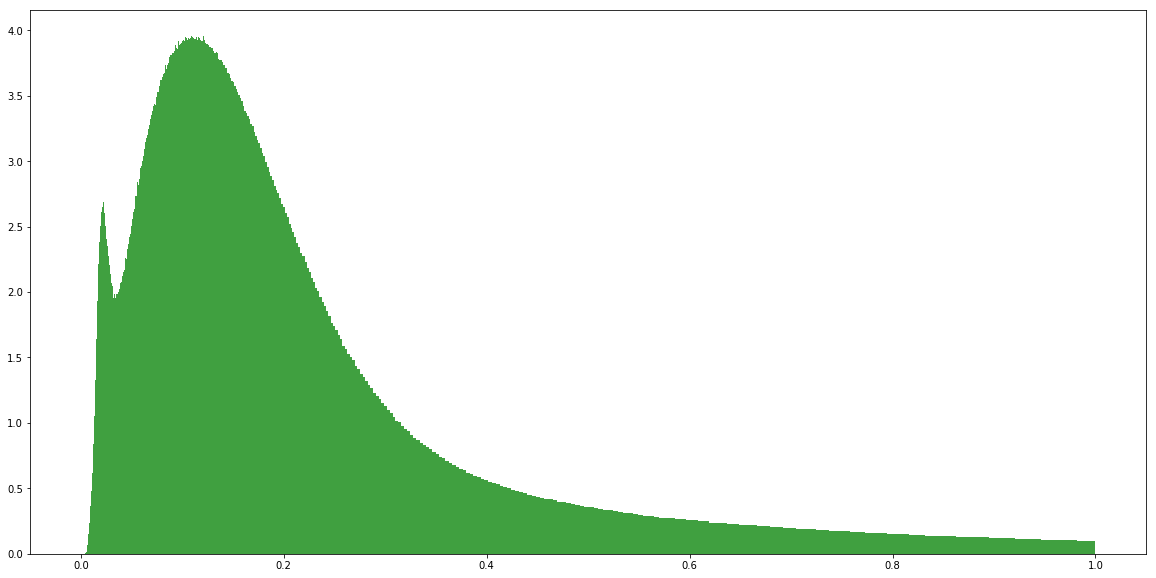

In [51]:
plt.hist(s0_data,bins=np.logspace(np.log10(0.0001),np.log10(1.0),1000),density=True,facecolor='g', alpha=0.75)
plt.show()

# Binarization

In [67]:
width = speckle_filter.getSceneRasterWidth()
height = speckle_filter.getSceneRasterHeight()
name = speckle_filter.getName()
description = speckle_filter.getDescription()
band_names = speckle_filter.getBandNames()

print("Product: %s, %d x %d pixels, %s" % (name, width, height, description))
print("Bands:   %s" % (list(band_names)))

snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
BandDescriptor = snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
targetBand1 = BandDescriptor()
targetBand1.name = 'band_1'
targetBand1.type = 'float32'
targetBand1.expression = '(Sigma0_VV<0.03)'
targetBands = snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand1

parameters = HashMap()
parameters.put('targetBands', targetBands)
result = snappy.GPF.createProduct('BandMaths', parameters, speckle_filter)
print("Writing...")

ProductIO.writeProduct(result, 'snappy_bmaths_output.dim', 'BEAM-DIMAP')

print("Done.")

Product: corrected_VV_Spk, 7221 x 5450 pixels, None
Bands:   ['Sigma0_VV']
Writing...
Done.


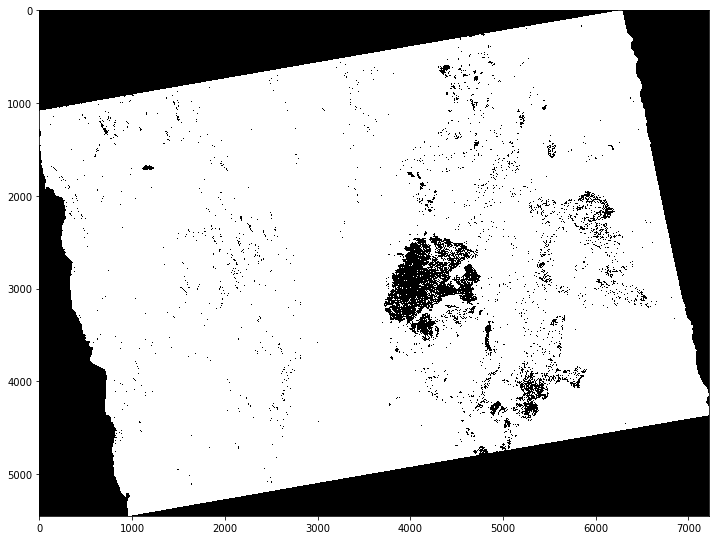

In [69]:
%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot 

plotBand(result, 'band_1' , 0, 0.3)